# reference https://towardsdatascience.com/time-series-in-python-part-3-forecasting-taxi-trips-with-lstms-277afd4f811

In [16]:


%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd
import numpy as np
import statsmodels as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6



In [2]:
!ls -ltr

total 31786040
-rw-r--r--  1 joydeepbhattacharjee  staff  1402245164 Mar 18  2019 fhv_tripdata_2018-01.csv
-rw-r--r--  1 joydeepbhattacharjee  staff  1573523090 Mar 18  2019 fhv_tripdata_2018-09.csv
-rw-r--r--  1 joydeepbhattacharjee  staff  1654884183 Mar 18  2019 fhv_tripdata_2018-10.csv
-rw-r--r--  1 joydeepbhattacharjee  staff  1625120711 Mar 18  2019 fhv_tripdata_2018-11.csv
-rw-r--r--  1 joydeepbhattacharjee  staff  1694806758 Mar 18  2019 fhv_tripdata_2018-12.csv
-rw-r--r--  1 joydeepbhattacharjee  staff  1301971512 Sep 19 01:02 fhv_tripdata_2019-01.csv
-rw-r--r--  1 joydeepbhattacharjee  staff  1331289760 Sep 19 01:04 fhvhv_tripdata_2019-06.csv
-rw-r--r--  1 joydeepbhattacharjee  staff  1416176511 Sep 19 01:04 fhvhv_tripdata_2019-05.csv
-rw-r--r--  1 joydeepbhattacharjee  staff  1378874062 Sep 19 01:04 fhvhv_tripdata_2019-04.csv
-rw-r--r--  1 joydeepbhattacharjee  staff  1514101716 Sep 19 01:04 fhvhv_tripdata_2019-03.csv
-rw-r--r--  1 joydeepbhattacharjee  staff  1279994273 Sep

In [3]:
trips_df_2018_12 = pd.read_csv("fhv_tripdata_2018-12.csv")
trips_df_2018_11 = pd.read_csv("fhv_tripdata_2018-11.csv")
trips_df_2018_10 = pd.read_csv("fhv_tripdata_2018-10.csv")
trips_df_2018_09 = pd.read_csv("fhv_tripdata_2018-09.csv")
trips_df_2019_01 = pd.read_csv("fhv_tripdata_2019-01.csv")
trips_df_2019_02 = pd.read_csv("fhvhv_tripdata_2019-02.csv")
trips_df_2019_03 = pd.read_csv("fhvhv_tripdata_2019-03.csv")
trips_df_2019_04 = pd.read_csv("fhvhv_tripdata_2019-04.csv")
trips_df_2019_05 = pd.read_csv("fhvhv_tripdata_2019-05.csv")
trips_df_2019_06 = pd.read_csv("fhvhv_tripdata_2019-06.csv")

In [4]:
trips_df_2018_10.columns

Index(['Pickup_DateTime', 'DropOff_datetime', 'PUlocationID', 'DOlocationID',
       'SR_Flag', 'Dispatching_base_number', 'Dispatching_base_num'],
      dtype='object')

In [5]:
def only_pick_datetimes(trips_df):
    cols = ["pickup_datetime", "dropoff_datetime"]
    trips_df.columns = [x.lower() for x in trips_df.columns]
    return trips_df[cols]

In [6]:
all_trip_dfs = [trips_df_2018_09, trips_df_2018_10, trips_df_2018_11,
                trips_df_2018_12, trips_df_2019_01,
                trips_df_2019_02, trips_df_2019_03,
                trips_df_2019_04, trips_df_2019_05,
                trips_df_2019_06]
all_trip_dfs = [only_pick_datetimes(df) for df in all_trip_dfs]

In [7]:
all_trip_dfs[0].head()

,pickup_datetime,dropoff_datetime
0,2018-09-29 00:04:41,2018-09-29 00:25:54
1,2018-09-29 00:04:45,2018-09-29 00:38:30
2,2018-09-29 00:05:11,2018-09-29 00:32:54
3,2018-09-29 00:05:14,2018-09-29 00:09:40
4,2018-09-29 00:07:56,2018-09-29 00:13:05


In [8]:
trips_df = pd.concat(all_trip_dfs)

In [9]:
trips_df.head()

,pickup_datetime,dropoff_datetime
0,2018-09-29 00:04:41,2018-09-29 00:25:54
1,2018-09-29 00:04:45,2018-09-29 00:38:30
2,2018-09-29 00:05:11,2018-09-29 00:32:54
3,2018-09-29 00:05:14,2018-09-29 00:09:40
4,2018-09-29 00:07:56,2018-09-29 00:13:05


In [10]:
trips_df["date"] = trips_df["pickup_datetime"].apply(lambda x: x.split()[0])

In [11]:
trips_df.head()

,pickup_datetime,dropoff_datetime,date
0,2018-09-29 00:04:41,2018-09-29 00:25:54,2018-09-29
1,2018-09-29 00:04:45,2018-09-29 00:38:30,2018-09-29
2,2018-09-29 00:05:11,2018-09-29 00:32:54,2018-09-29
3,2018-09-29 00:05:14,2018-09-29 00:09:40,2018-09-29
4,2018-09-29 00:07:56,2018-09-29 00:13:05,2018-09-29


In [12]:
trips_df["date"] = pd.to_datetime(trips_df["date"])

In [13]:
number_of_trips_per_date = trips_df.groupby(["date"]).size()

In [14]:
number_of_trips_per_date.head()

date
2018-09-01    765027
2018-09-02    718121
2018-09-03    625851
2018-09-04    679351
2018-09-05    708196
dtype: int64

In [24]:
number_of_trips_per_date.tail()

date
2019-02-05    576476
2019-02-06    663516
2019-02-07    649575
2019-02-08    780194
2019-02-09    148388
dtype: int64

In [25]:
number_of_trips_per_date

date
2019-02-01    860161
2019-02-02    866393
2019-02-03    756721
2019-02-04    592170
2019-02-05    576476
2019-02-06    663516
2019-02-07    649575
2019-02-08    780194
2019-02-09    148388
dtype: int64

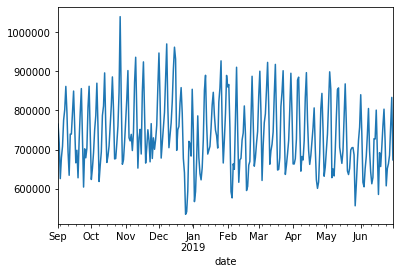

In [15]:
number_of_trips_per_date.plot()

In [17]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(timeseries, window):
    rol_mean = timeseries.rolling(window=window).mean()
    rol_std = timeseries.rolling(window=window).std()
    
    # plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='original')
    mean = plt.plot(rol_mean, color='red', label='ROlling mean')
    std = plt.plot(rol_std, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title("rolling mean and standard deviation")
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    timeseries = timeseries.dropna()
    dftest = adfuller(timeseries, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=["test statistic", 'p-value', "#lags used", 'number of observations used'])
    for k, v in dftest[4].items():
        dfoutput['Critical value {}'.format(k)] = v

    print(dfoutput)

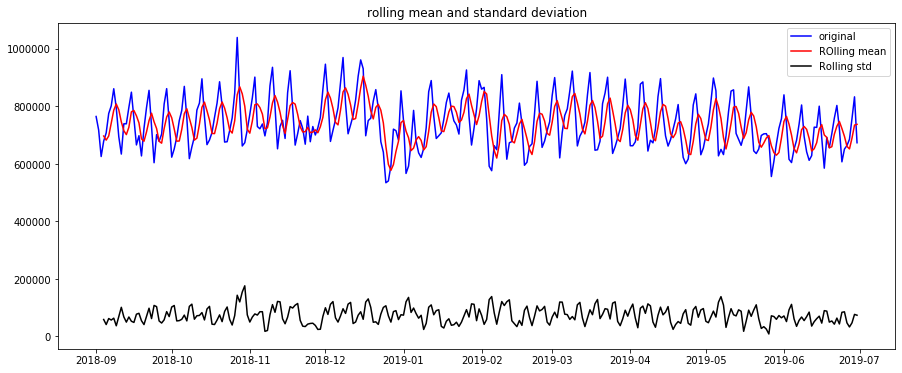

Results of dickey fuller test
test statistic                  -3.846254
p-value                          0.002468
#lags used                      16.000000
number of observations used    286.000000
Critical value 1%               -3.453423
Critical value 5%               -2.871699
Critical value 10%              -2.572183
dtype: float64


In [18]:
test_stationary(number_of_trips_per_date, 4)

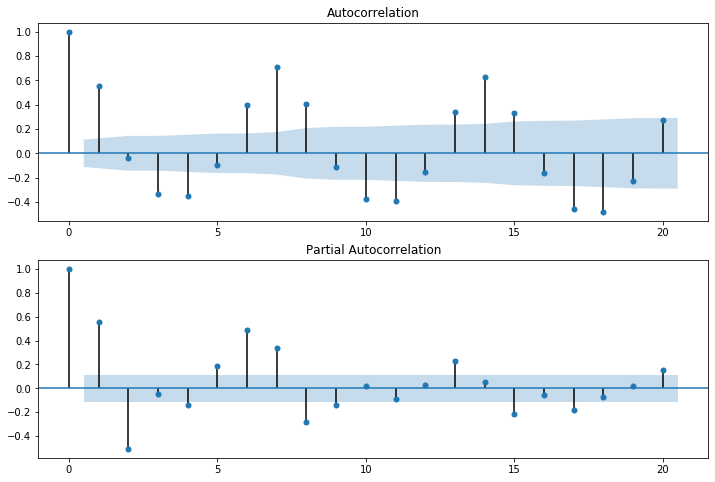

In [19]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(number_of_trips_per_date, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(number_of_trips_per_date, lags=20, ax=ax2)

/Users/joydeepbhattacharjee/miniconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


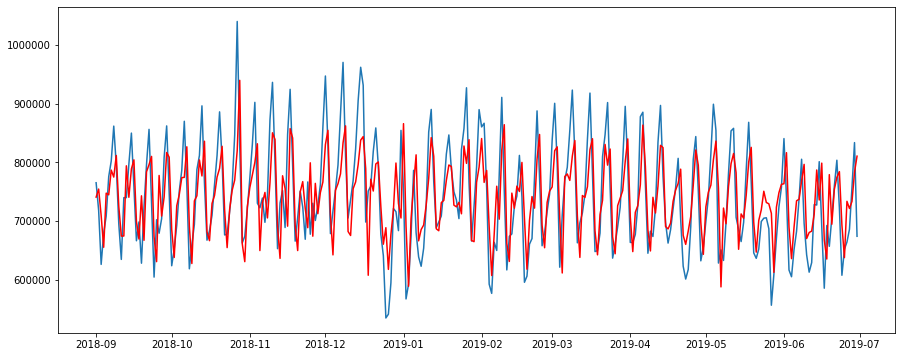

In [20]:
model = ARIMA(number_of_trips_per_date, order=(2, 0, 0))
results_AR2 = model.fit()
plt.plot(number_of_trips_per_date)
plt.plot(results_AR2.fittedvalues, color='red')

In [21]:
results_AR2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  303
Model:                     ARMA(2, 0)   Log Likelihood               -3782.065
Method:                       css-mle   S.D. of innovations          63672.577
Date:                Fri, 07 Feb 2020   AIC                           7572.129
Time:                        09:00:03   BIC                           7586.984
Sample:                    09-01-2018   HQIC                          7578.072
                         - 06-30-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.405e+05   5506.609    134.479      0.000     7.3e+05    7.51e+05
ar.L1.y        0.8450      0.050     17.055      0.000       0.748       0.942
ar.L2.y       -0.5099      0.049    -10.307      0.000      -0.607      -0.413
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8287           -1.1290j            1.4005           -0.1492
AR.2            0.8287           +1.1290j            1.4005            0.1492
-----------------------------------------------------------------------------
"""

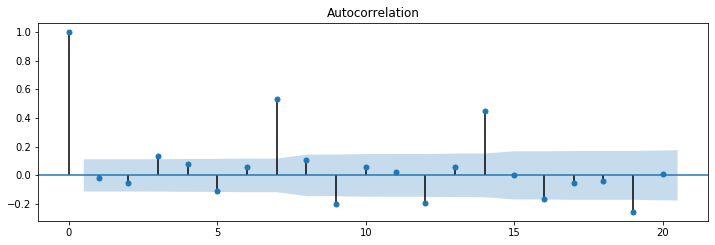

In [22]:
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_AR2.resid, lags=20, ax=ax1)

Text(0.5, 1.0, 'Residuals 2, 0, 0 vs Normal distribution mean = -207.11, std = 63688.68')

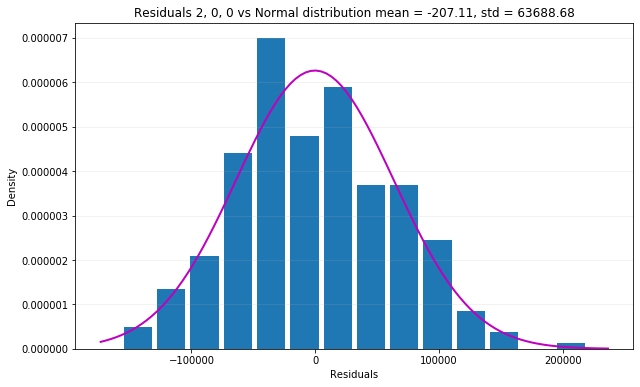

In [23]:
from scipy.stats import norm

plt.figure(figsize=(10, 6))
plt.hist(results_AR2.resid, bins='auto', density=True, rwidth=0.85, label='Residuals') # density true normal dist line curve
mu, std = norm.fit(results_AR2.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals 2, 0, 0 vs Normal distribution mean = ' + str(round(mu, 2)) + ', std = ' + str(round(std, 2)))

/Users/joydeepbhattacharjee/miniconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


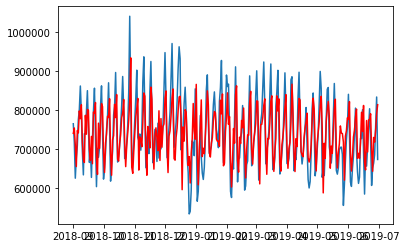

In [24]:


model = ARIMA(number_of_trips_per_date, order=(4, 0, 0))
results_AR4 = model.fit()
plt.plot(number_of_trips_per_date)
plt.plot(results_AR4.fittedvalues, color='red')



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  303
Model:                     ARMA(4, 0)   Log Likelihood               -3779.052
Method:                       css-mle   S.D. of innovations          63034.771
Date:                Fri, 07 Feb 2020   AIC                           7570.104
Time:                        09:02:29   BIC                           7592.386
Sample:                    09-01-2018   HQIC                          7579.018
                         - 06-30-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.405e+05   4639.548    159.612      0.000    7.31e+05     7.5e+05
ar.L1.y        0.8211      0.057     14.329      0.000       0.709       0.933
ar.L2.y       -0.5447      0.075     -7.303      0.0

Text(0.5, 1.0, 'Residuals 2, 0, 0 vs Normal distribution mean = -175.86, std = 63055.61')

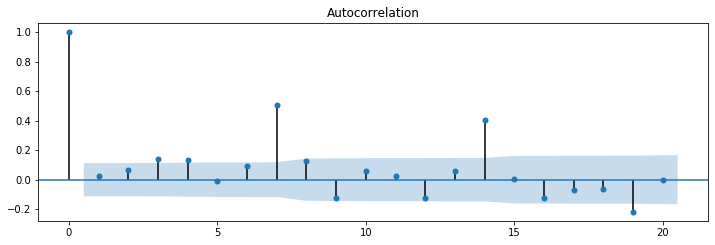

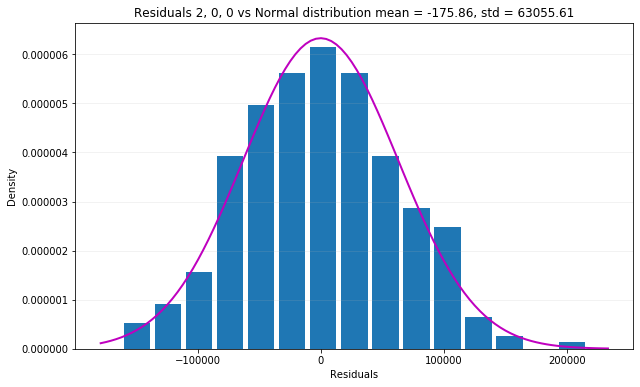

In [27]:


# model summary
print(results_AR4.summary())

# acf on residuals of the model
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_AR4.resid, lags=20, ax=ax1)

# histogram of the residuals
from scipy.stats import norm

plt.figure(figsize=(10, 6))
plt.hist(results_AR4.resid, bins='auto', density=True, rwidth=0.85, label='Residuals') # density true normal dist line curve
mu, std = norm.fit(results_AR4.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals 2, 0, 0 vs Normal distribution mean = ' + str(round(mu, 2)) + ', std = ' + str(round(std, 2)))



In [31]:
forecast_400 = results_AR4.predict(start='2019-07-01', end='2019-07-10')

In [30]:
number_of_trips_per_date.tail()

date
2019-06-26    663954
2019-06-27    685769
2019-06-28    757581
2019-06-29    833418
2019-06-30    673738
dtype: int64

In [32]:
forecast_400

2019-07-01    643900.296922
2019-07-02    702477.270744
2019-07-03    744020.282672
2019-07-04    765722.735306
2019-07-05    769553.645993
2019-07-06    756106.424189
2019-07-07    738990.815749
2019-07-08    729595.008289
2019-07-09    729632.744645
2019-07-10    735286.691057
Freq: D, dtype: float64

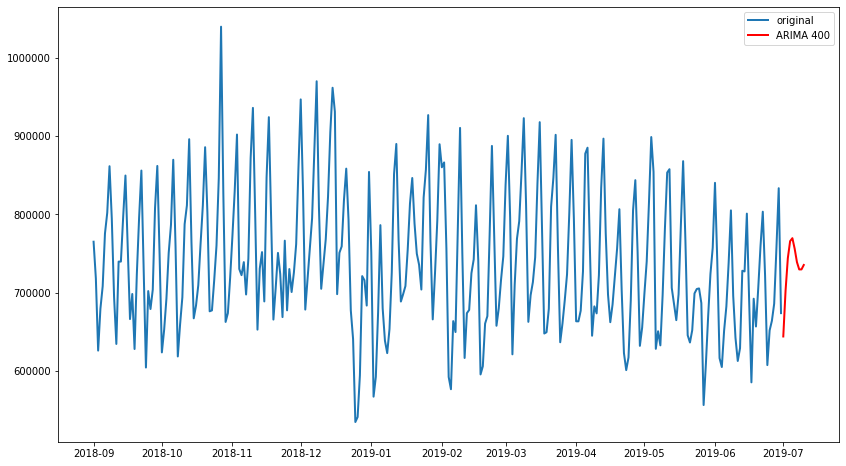

In [36]:
plt.figure(figsize=(14, 8))
plt.plot(number_of_trips_per_date, linewidth=2, label="original")
plt.plot(forecast_400, linewidth=2, color='red', label="ARIMA 400")
# plt.plot(forecast_202, linewidth=2, color='blue', label="ARIMA 202")
plt.legend()

In [32]:
def create_dataset(dataset, look_back=1, forecast_horizon=1, batch_size=1):
    batch_x, batch_y, batch_z = [], [], []
    for i in range(0, len(dataset)-look_back-forecast_horizon-batch_size+1, batch_size):
        for n in range(batch_size):            
            x = dataset[['log_counts','next_is_holiday','next_bad_weather']].values[i+n:(i + n + look_back), :]
            offset = x[0, 0]
            y = dataset['log_counts'].values[i + n + look_back:i + n + look_back + forecast_horizon]
            batch_x.append(np.array(x).reshape(look_back, -1))
            batch_y.append(np.array(y))
            batch_z.append(np.array(offset))
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        batch_z = np.array(batch_z)
        batch_x[:, :, 0] -= batch_z.reshape(-1, 1)
        batch_y -= batch_z.reshape(-1, 1)
        yield batch_x, batch_y, batch_z
        batch_x, batch_y, batch_z = [], [], []

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Model(nn.Module):
    def __init__(self, config):
        super(Model, self).__init__()
        self.hidden_size = 128
        self.bi = 1
        self.lstm = nn.LSTM(config.get('features'),self.hidden_size,1,dropout=0.1,bidirectional=self.bi-1,batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size,self.hidden_size // 4,1,dropout=0.1,bidirectional=self.bi-1,batch_first=True)
        self.dense = nn.Linear(self.hidden_size // 4, config.get('forecast_horizon'))
        self.loss_fn = nn.MSELoss()
        
    def forward(self, x, batch_size=100):
        hidden = self.init_hidden(batch_size)
        output, _ = self.lstm(x, hidden)
        output = F.dropout(output, p=0.5, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        output = F.dropout(output, p=0.5, training=True)
        output = self.dense(state[0].squeeze(0))
        
        return output
        
    def init_hidden(self, batch_size):
        h0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size))
        c0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size))
        return h0, c0
    
    def init_hidden2(self, batch_size):
        h0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size//4))
        c0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size//4))
        return h0, c0
    
    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

In [34]:
# !conda install -c pytorch pytorch -y

In [35]:
df = trips_df

In [36]:
batch_size = 1
forecast_horizon = 1
look_back = 28
model = Model(dict(features=3, forecast_horizon=1))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 5

model.train()
train_true_y = []
train_pred_y = []
for epoch in range(n_epochs):
    ep_loss = []
    for i, batch in enumerate(create_dataset(df[df.index<"2018"], look_back=look_back, forecast_horizon=1, batch_size=batch_size)):
        print("[{}{}] Epoch {}: loss={:0.4f}".format("-"*(20*i//(len(df[df.index<"2018"])//batch_size)), " "*(20-(20*i//(len(df[df.index<"2018"])//batch_size))),epoch, np.mean(ep_loss)), end="\r")
        try:
            batch = [torch.Tensor(x) for x in batch]
        except:
            break

        out = model.forward(batch[0].float(), batch_size)
        loss = model.loss(out, batch[1].float())
        if epoch == n_epochs - 1:
            train_true_y.append((batch[1] + batch[2]).detach().numpy().reshape(-1))
            train_pred_y.append((out + batch[2]).detach().numpy().reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ep_loss.append(loss.item())
    print()

/Users/joydeepbhattacharjee/miniconda3/envs/venv/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [37]:
df[df.index<"2018"]

,pickup_datetime,dropoff_datetime
date,,


In [38]:
df.head()

,pickup_datetime,dropoff_datetime
date,,
2018-01-30,2018-01-30 21:06:50,2018-01-30 21:15:34
2018-01-30,2018-01-30 21:20:36,2018-01-30 21:35:29
2018-01-30,2018-01-30 21:04:45,2018-01-30 21:16:34
2018-01-30,2018-01-30 21:11:51,2018-01-30 21:40:35
2018-01-30,2018-01-30 21:43:39,2018-01-30 21:49:59
